In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [10]:
df = pd.read_csv("House Price Prediction Dataset.csv") 

In [11]:
print(df.shape)
display(df.head())

(2000, 10)


,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [14]:
num_cols = ["Area", "Bedrooms", "Bathrooms", "Floors", "YearBuilt"]
cat_cols = ["Location", "Condition", "Garage"]        # 'Garage' = Yes/No

X = df[num_cols + cat_cols]
y = df["Price"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

In [15]:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot" , OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [17]:
lin_model = Pipeline([
    ("prep", preprocess),
    ("reg" , LinearRegression())
]).fit(X_train, y_train)

In [18]:
gbr_model = Pipeline([
    ("prep", preprocess),
    ("gbr" , GradientBoostingRegressor(
                 n_estimators=300,
                 learning_rate=0.05,
                 max_depth=3,
                 random_state=42))
]).fit(X_train, y_train)

In [19]:
def evaluate(model, name):
    pred  = model.predict(X_test)
    mae   = mean_absolute_error(y_test, pred)
    rmse  = mean_squared_error(y_test, pred, squared=False)
    print(f"{name:18s} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f}")
    return pred, mae, rmse

lin_pred, lin_mae, lin_rmse = evaluate(lin_model, "Linear Regression")
gbr_pred, gbr_mae, gbr_rmse = evaluate(gbr_model, "Gradient Boosting")

best_pred = gbr_pred if gbr_rmse < lin_rmse else lin_pred
best_tag  = "Gradient Boosting" if gbr_rmse < lin_rmse else "Linear Regression"

Linear Regression  | MAE: 243,242 | RMSE: 279,860
Gradient Boosting  | MAE: 248,172 | RMSE: 287,634


C:\Users\PMYLS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\PMYLS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


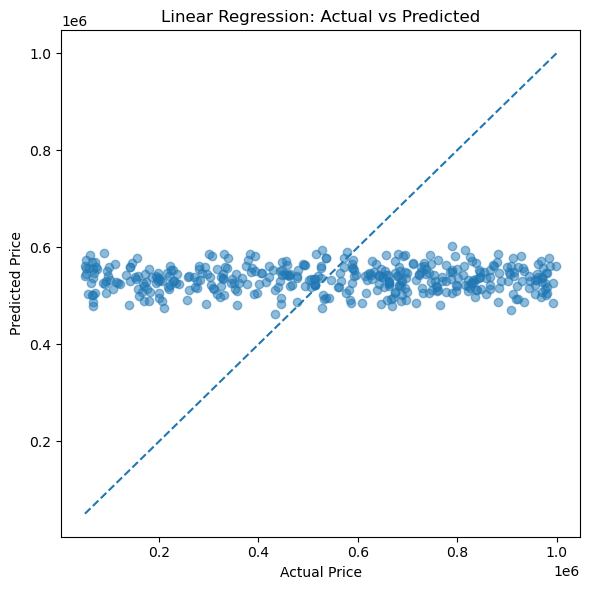

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"{best_tag}: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [22]:
if best_tag == "Gradient Boosting":
    gbr       = gbr_model.named_steps["gbr"]
    onehot    = gbr_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    feat_names = num_cols + list(onehot.get_feature_names_out(cat_cols))
    importances = (pd.Series(gbr.feature_importances_, index=feat_names)
                     .sort_values(ascending=False))
    display(importances.head(10))